## <Telco Customer Churn: SQL + Python Analysis>
#### 고객 이탈을 유발하는 핵심 세그먼트를 **운영 DB 기준 KPI로 구조적으로 검증**

- 본 노트북은 MySQL에 적재된 Telco Customer Churn 데이터를 기반으로 SQL을 활용해 KPI를 정의 및 집계하고,  
  Python(Pandas)으로 검증·추가 분석을 수행한 과정입니다.

- 해당 분석 결과는 Streamlit 대시보드로 시각화 및 의사결정 지원을 목적으로 활용됩니다.

### 1. 데이터베이스 연결 및 데이터 확인

MySQL에 적재된 Telco Customer Churn 운영 데이터를 Python 분석 환경으로 불러와,  
SQL 기반 분석이 가능한 상태인지 사전 점검합니다.

본 단계에서는 운영 DB를 직접 조회하는 상황을 가정하여,  
데이터 정합성과 컬럼 구조를 우선적으로 확인합니다.

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()

engine = create_engine(
    f"mysql+pymysql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}"
    f"@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
)


In [2]:
query = "SELECT * FROM telco_churn;"
df = pd.read_sql(query, engine)
df.shape

(7032, 21)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2. 핵심 KPI 산출 (전체 고객 수 및 이탈 현황)

운영 데이터 기준으로 전체 고객 규모와 이탈 현황을 집계하여 이후 세부 세그먼트 분석 전반의 기준선을 설정합니다.  

본 단계에서는 **전체 고객 수, 이탈 고객 수, 이탈률을 핵심 KPI**로 정의하고, SQL 집계 결과를 기준값으로 사용합니다.  
Python은 해당 결과의 정합성 검증 용도로만 활용합니다.

In [4]:
# SQL KPI 조회
query_kpi = """
SELECT
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churn_customers,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churn_rate
FROM telco_churn;
"""
sql_kpi = pd.read_sql(query_kpi, engine)

# Pandas KPI 재계산
pandas_kpi = pd.DataFrame([{
    "total_customers": len(df),
    "churn_customers": (df["Churn"] == "Yes").sum(),
    "churn_rate": (df["Churn"] == "Yes").mean()
}])

print("SQL KPI와 Pandas KPI가 거의 일치합니다 (소수점 미세 차이 무시).")

sql_kpi, pandas_kpi


SQL KPI와 Pandas KPI가 거의 일치합니다 (소수점 미세 차이 무시).


(   total_customers  churn_customers  churn_rate
 0             7032           1869.0      0.2658,
    total_customers  churn_customers  churn_rate
 0             7032             1869    0.265785)

※ 상기 KPI는 MySQL에서 집계한 결과와 Pandas 기반 재계산 결과가 동일함을 확인했습니다.

### 3. tenure_group 생성 (SQL CASE WHEN 로직과 동일)
이후 분석 및 streamlit 대시보드와의 집계 기준 일관성을 위해,  
SQL에서 사용하는 CASE WHEN 로직과 동일한 기준으로 `tenure_group`을 Python에서도 사전에 정의합니다.

In [5]:
def tenure_grouping(x):
    if x < 6:
        return "0-5개월"
    elif x < 12:
        return "6-11개월"
    elif x < 24:
        return "12-23개월"
    else:
        return "24개월 이상"

df["tenure_group"] = df["tenure"].apply(tenure_grouping)

tenure_order = ["0-5개월", "6-11개월", "12-23개월", "24개월 이상"]

df["tenure_group"] = pd.Categorical(
    df["tenure_group"],
    categories=tenure_order,
    ordered=True
)

이후 본 노트북에서 사용되는 `tenure_group`은 모두 이 기준을 따릅니다.

### 4. 계약 유형별 고객 이탈 분석 (SQL 집계)  
이탈 구조의 1차적인 차이를 **운영 DB 기준에서 빠르게 확인**하기 위해 계약 유형별 고객 이탈률을 SQL로 집계합니다.

본 분석은 2장에서 정의한 이탈률 KPI를 `Contract` 기준으로 분해한 결과이며,  
아래 집계 결과는 이후 Streamlit 대시보드의 **Contract → Churn** 섹션에 그대로 사용됩니다.  

> ※ 참고  
`tenure`는 단독 변수로서 이탈 설명력이 매우 높지만,  
운영 KPI 관점에서는 개별 변수보다 **이탈 위험 세그먼트 식별이 더 중요**합니다.
이에 따라 본 노트북에서는 `tenure`를 단독 KPI로 사용하지 않고,  
이후 `Contract` 및 `InternetService`와 결합된 형태로 활용합니다.

```sql
SELECT
    Contract,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churn_rate
FROM telco_churn
GROUP BY Contract
ORDER BY churn_rate DESC;
```

**결과 요약**
- Month-to-month 계약 고객의 이탈률이 가장 높음
- 1년·2년 장기 계약 고객은 상대적으로 안정적

→ **단기 계약 고객이 이탈 위험이 높은 핵심 세그먼트**로 식별됨

### 5. 월 요금(MonthlyCharges) 분포 재확인 (tenure 구간별, Churn 기준)

본 섹션은 월 요금이 이탈의 원인임을 재검증하기 위한 분석이 아니라,  
EDA에서 관찰된 **'초기 구간 + 고비용' 패턴이 운영 DB에서도 동일하게 나타나는지를 확인**하기 위한 보조 검증 단계입니다.  
  
해당 패턴이 재현됨을 확인한 뒤,  
다음 섹션에서는 이를 유발하는 **계약 및 서비스 구조 요인**을 조합 분석으로 검증합니다.

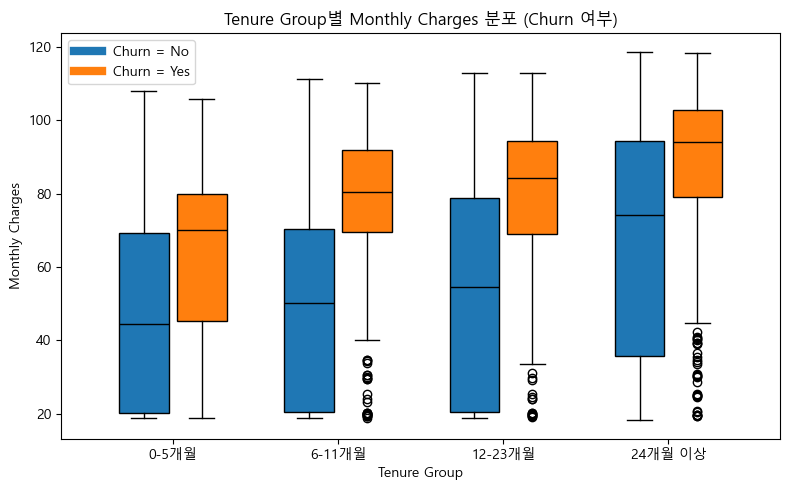

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np


rcParams["font.family"] = "NanumGothic"
rcParams["axes.unicode_minus"] = False

# tenure_group 정렬
tenure_groups = df["tenure_group"].cat.categories

# 박스플롯용 데이터 구성
data_no = [
    df[(df["tenure_group"] == tg) & (df["Churn"] == "No")]["MonthlyCharges"]
    for tg in tenure_groups
]

data_yes = [
    df[(df["tenure_group"] == tg) & (df["Churn"] == "Yes")]["MonthlyCharges"]
    for tg in tenure_groups
]

x = np.arange(len(tenure_groups))
width = 0.35

plt.figure(figsize=(8, 5))

plt.boxplot(
    data_no,
    positions=x - width / 2,
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="#1f77b4"),
    medianprops=dict(color="black")
)

plt.boxplot(
    data_yes,
    positions=x + width / 2,
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="#ff7f0e"),
    medianprops=dict(color="black")
)

plt.xticks(x, tenure_groups)
plt.xlabel("Tenure Group")
plt.ylabel("Monthly Charges")
plt.title("Tenure Group별 Monthly Charges 분포 (Churn 여부)")

plt.legend(
    handles=[
        plt.Line2D([0], [0], color="#1f77b4", lw=6, label="Churn = No"),
        plt.Line2D([0], [0], color="#ff7f0e", lw=6, label="Churn = Yes"),
    ]
)

plt.tight_layout()
plt.show()


**결과 해석**
- 계약 유지 기간이 짧은 고객일수록 월 요금 분포의 변동성이 큼
- 특히 초기구간에서 이탈 고객의 월 요금 중앙값이 유지 고객 대비 상대적으로 높은 경향을 보임  
  
**해석 시 유의점**  
- 본 분석에서 관찰되는 월 요금 차이는 월 요금이 단독으로 고객 이탈을 유발한다는 의미가 아님  
- 월 요금은 고객의 **계약 유형 및 서비스 구조**와 결합될 때 이탈 가능성을 증폭시키는 보조 요인으로 해석하는 것이 타당함  

따라서 본 섹션의 목적은 '월 요금이 이탈의 직접 원인임'을 주장하기 위함이 아니라,  
**이후 계약 구조 변수와의 조합 분석 필요성을 확인하는 데 있음**

### 6. Contract × InternetService 조합 분석 (SQL → Python)

SQL을 사용해 Contract와 InternetService 조합별 이탈률을 빠르게 집계하고,  
Python(Pandas)에서는 동일 조합의 세밀한 분석과 시각화를 통해 추가 인사이트를 확보합니다.

```sql
SELECT
    Contract,
    InternetService,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churn_rate
FROM telco_churn
GROUP BY Contract, InternetService;
```

In [7]:
pivot = pd.pivot_table(
    df,
    values="Churn",
    index="Contract",
    columns="InternetService",
    aggfunc=lambda x: (x == "Yes").mean()
)

pivot

InternetService,DSL,Fiber optic,No
Contract,,,
Month-to-month,0.322159,0.546053,0.188931
One year,0.092982,0.192950,0.024793
Two year,0.019262,0.072261,0.007899


**결과 요약**
- Month-to-month 계약 x Fiber optic 사용 고객이 가장 높은 이탈률
- 장기 계약 x DSL 고객은 상대적으로 안정적

→ **계약 유형과 서비스 유형이 결합될 때 특정 세그먼트의 이탈 위험이 높음**을 확인

### 7. Streamlit 대시보드용 최종 집계 테이블 생성
앞선 분석에서 Fiber optic 서비스가 단변량·조합 분석 모두에서 가장 높은 이탈률을 보였기 때문에,  
Streamlit 대시보드에서는 해당 서비스 유형을 중심으로 **고위험 세그먼트를 집중 관리**합니다.  
  
Streamlit 대시보드에서 사용할 최종 KPI 테이블을 생성합니다.  
본 테이블은 SQL CASE WHEN 기준과 완전히 동일한 tenure_group을 사용합니다.

In [8]:
final_table = (
    df[df["InternetService"] == "Fiber optic"]
    .groupby(["Contract", "tenure_group"])
    .agg(
        churn_rate=("Churn", lambda x: (x == "Yes").mean()),
        customer_cnt=("customerID", "count")
    )
    .reset_index()
)
final_table

C:\Users\mars7\AppData\Local\Temp\ipykernel_22700\2780191013.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Contract", "tenure_group"])


,Contract,tenure_group,churn_rate,customer_cnt
0,Month-to-month,0-5개월,0.747826,575
1,Month-to-month,6-11개월,0.624585,301
2,Month-to-month,12-23개월,0.517401,431
3,Month-to-month,24개월 이상,0.390987,821
4,One year,0-5개월,1.000000,1
5,One year,6-11개월,0.000000,3
6,One year,12-23개월,0.200000,25
7,One year,24개월 이상,0.192157,510
8,Two year,0-5개월,NaN,0
9,Two year,6-11개월,NaN,0


**결과 해석**
- Fiber optic × Month-to-month × 0–5개월 세그먼트에서 이탈률 가장 높음
- 장기 계약과 결합된 세그먼트는 고객 수는 많지만 **상대적으로 안정적**

→ Streamlit 대시보드에서는 이 테이블을 기반으로 KPI 및 시각화를 자동 갱신 가능

### 8. 분석 요약 및 실무 활용 방안

- **단기 계약(Month-to-month) + Fiber optic 고객군에서 이탈 위험이 가장 높음**을 확인
- 특히 초기 이용 기간 고객을 대상으로 한 맞춤형 관리 전략이 필요
  (예: 프로모션 안내, 고객 상담 강화 등)
- 최종 분석 테이블과 KPI는 Streamlit 대시보드를 통해 아래와 같은 활용 가능
  - KPI 모니터링
  - 고위험 세그먼트 필터링
  - 정기 리포트 자동화